In [30]:
#the following packages are required for this project.
#to install them, uncomment the next lines, or run $pip install requirements.txt from project directory
#!pip install wordcloud
#!pip install keras
#!pip install tensorflow
#!pip install imblearn

# 1. Preparing data

Unzipping and storing files in "data" directory

In [2]:
import glob, os
import zipfile

for file in glob.glob("*.zip"):    
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall("data_raw")

Reading files for further exploration

In [3]:
import pandas as pd
import numpy as np

train_data = 'data_raw/train.csv'
train_data = pd.read_csv(train_data)
test_comments = 'data_raw/test.csv'
test_comments = pd.read_csv(test_comments)
test_labels = 'data_raw/test_labels.csv'
test_labels = pd.read_csv(test_labels)
embedding_file = 'data_raw/glove.6B.100d.txt'

# 2. Exploratory data analysis

## 2.1 Overview of training and test sets

In [4]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
print("The total number of comments in training set is", train_data.shape[0])

The total number of comments in training set is 159571


In [6]:
test_comments.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [7]:
print("The total number of comments in test set is", test_comments.shape[0])

The total number of comments in test set is 153164


In [8]:
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [9]:
print("The total number of labels in test set is", test_labels.shape[0])

The total number of labels in test set is 153164


## 2.2 Diagnostics

Checking for duplicates in comments

In [10]:
print("Number of duplicates in training set:", train_data[train_data['comment_text'].duplicated(keep=False)].shape[0])

Number of duplicates in training set: 0


In [11]:
print("Number of duplicates in test set:", test_comments[test_comments['comment_text'].duplicated(keep=False)].shape[0])

Number of duplicates in test set: 0


Cheking for null values in training set

In [12]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Cheking for null values in test set

In [13]:
test_comments.isnull().sum()

id              0
comment_text    0
dtype: int64

## 2.3 Exploring training set

Adding a label for neutral comment

In [14]:
outputs_train = list(train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']])
neutral = train_data[outputs_train].sum(axis=1)

train_data['neutral'] = (neutral == 0).astype("int")
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


### 2.3.1 Visualizing comments per label in training set

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


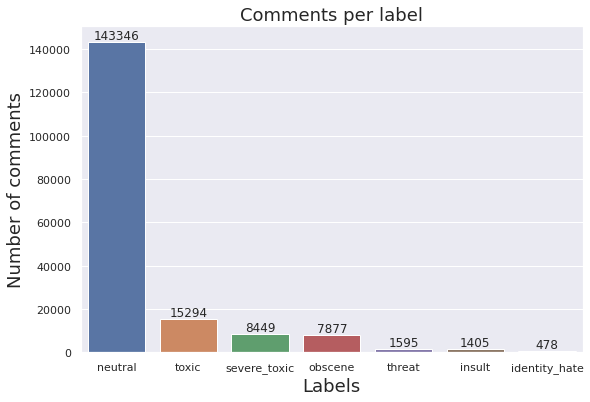

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

outputs_train = list(train_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']])
sns.set(font_scale = 1)
plt.figure(figsize=(9,6))
ax = sns.barplot(outputs_train, 
                 sorted(train_data[['neutral','toxic','severe_toxic','obscene',
                               'threat','insult','identity_hate']].sum().values, reverse=True))
plt.title("Comments per label", fontsize=18)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = sorted(train_data[['neutral','toxic','severe_toxic','obscene',
                       'threat','insult','identity_hate']].sum().values, reverse=True)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### 2.3.2 Visualizing comments per number of labels in training set

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


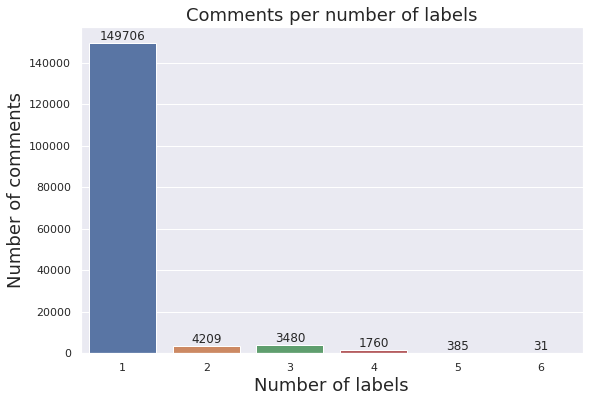

In [16]:
rowSums = train_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
sns.set(font_scale = 1)
plt.figure(figsize=(9,6))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments per number of labels", fontsize=18)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

# 3. Feature engineering

## 3.1 Preparing test data

In [17]:
test_data = pd.merge(test_comments, test_labels, on=['id'])
test_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


Adding a label for neutral comment

In [18]:
outputs_test = list(test_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']])
neutral = test_data[outputs_test].sum(axis=1)

test_data['neutral'] = (neutral == 0).astype("int")
outputs_test = list(test_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']])
test_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1,0
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,1
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,-1,-1,-1,-1,-1,-1,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,1
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",-1,-1,-1,-1,-1,-1,0
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,-1,-1,-1,-1,-1,-1,0


Drop values not used for scoring (-1)

In [19]:
for cols in test_data[outputs_test]:
    test_data = test_data[test_data[cols] >= 0]
    test_data = test_data.reset_index(drop=True)
    
test_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,1
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,1
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,1
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,1
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0,1
63974,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0,1
63975,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0,1
63976,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0,0


## 3.2 Processing the training and test data

### 3.2.1 Cleaning comments

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

def comment_to_words(comment):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = str(comment)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    
    return words

Cache processing comments since it can take a long time

In [21]:
#from https://github.com/udacity/sagemaker-deployment/blob/master/Project/SageMaker%20Project.ipynb
import pickle

cache_dir = "cache"  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_comments(data_train, data_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [comment_to_words(comment) for comment in data_train]
        words_test = [comment_to_words(comment) for comment in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test = (cache_data['words_train'], cache_data['words_test'])
    
    return words_train, words_test

In [22]:
# Preprocess data
words_train, words_test = preprocess_comments(train_data['comment_text'], test_data['comment_text'])

Read preprocessed data from cache file: preprocessed_data.pkl


In [23]:
train_data['comment_words'] = [" ".join(i) for i in words_train]
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_words
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,aww matches background colour seemingly stuck ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,make real suggestions improvement wondered sec...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,sir hero chance remember page
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1,second time asking view completely contradicts...
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1,ashamed horrible thing put talk page 128 61 19 93
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1,spitzer umm theres actual article prostitution...
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1,looks like actually put speedy first version d...


In [24]:
test_data['comment_words'] = [" ".join(i) for i in words_test]
test_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_words
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,1,thank understanding think highly would revert ...
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,1,dear god site horrible
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,1,somebody invariably try add religion really me...
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,1,says right type type institution needed case t...
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,1,adding new product list make sure relevant add...
...,...,...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0,1,jerome see never got around surprised looked e...
63974,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0,1,lucky bastard http wikimediafoundation org wik...
63975,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0,1,shame want speak gays romanians
63976,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0,0,mel gibson nazi bitch makes shitty movies much...


### 3.2.2 Visualizing word clouds for training set

In [25]:
from wordcloud import WordCloud

def display_cloud(data, label):
    wordcloud=WordCloud(max_words=3000, width=800,height=400,background_color='black').generate(data)
    plt.figure(figsize=(24,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for {}".format(label), fontsize=18)
    plt.show()

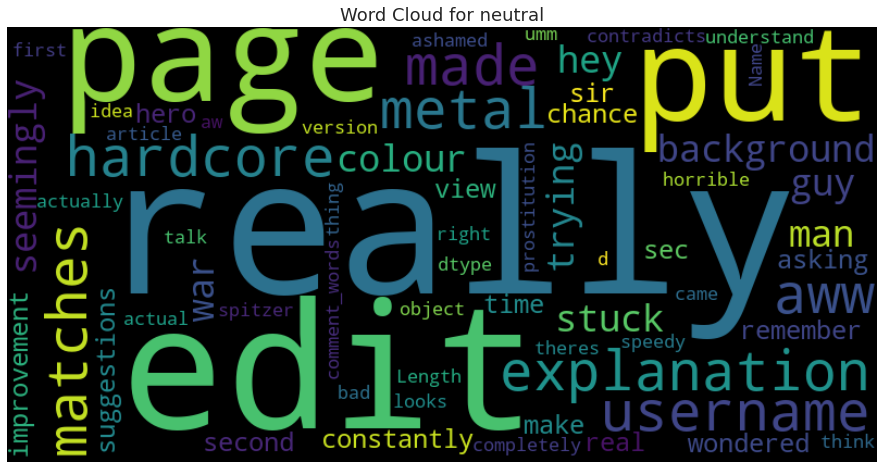

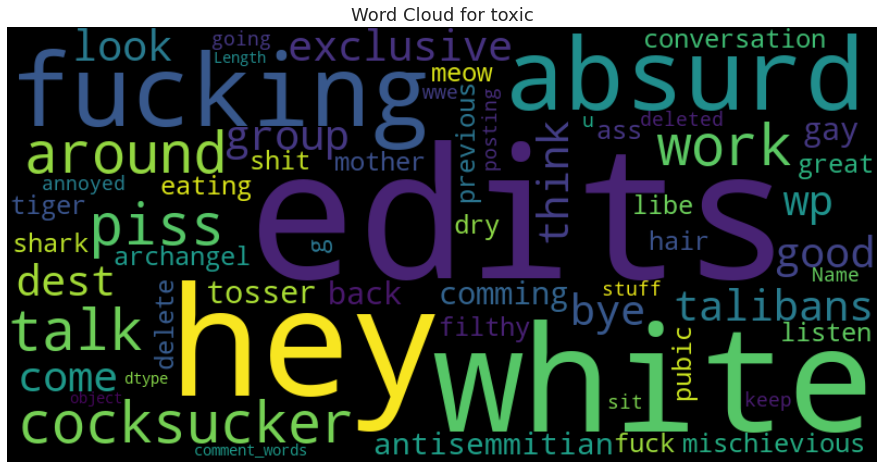

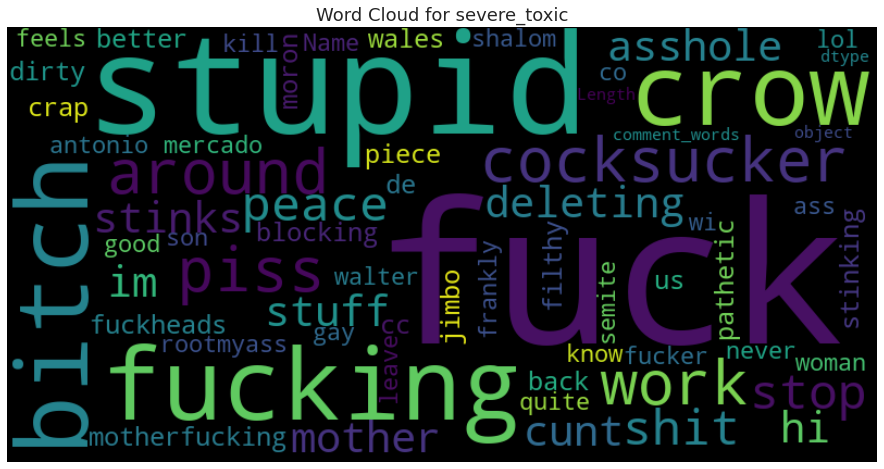

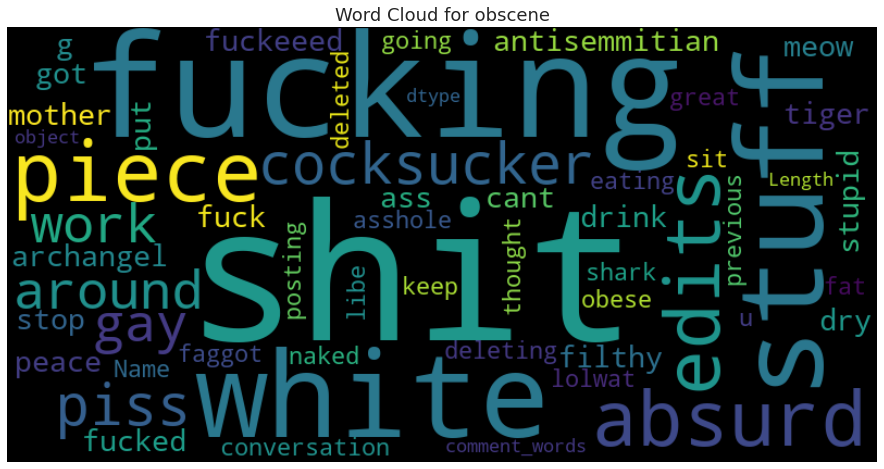

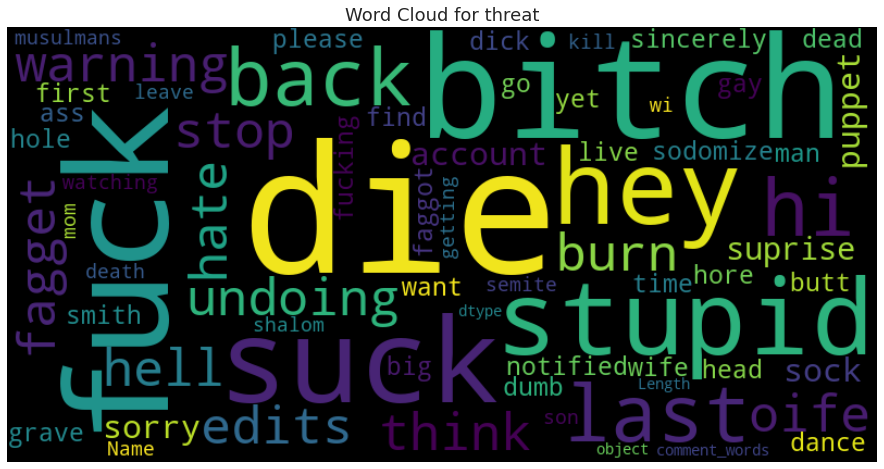

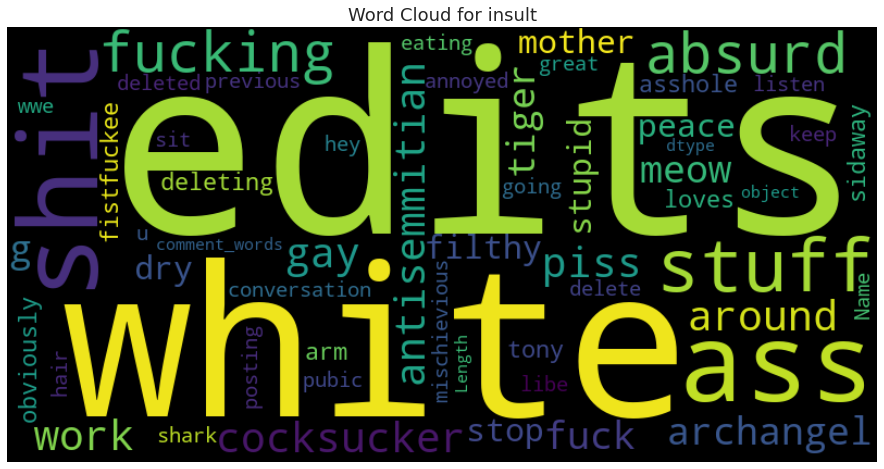

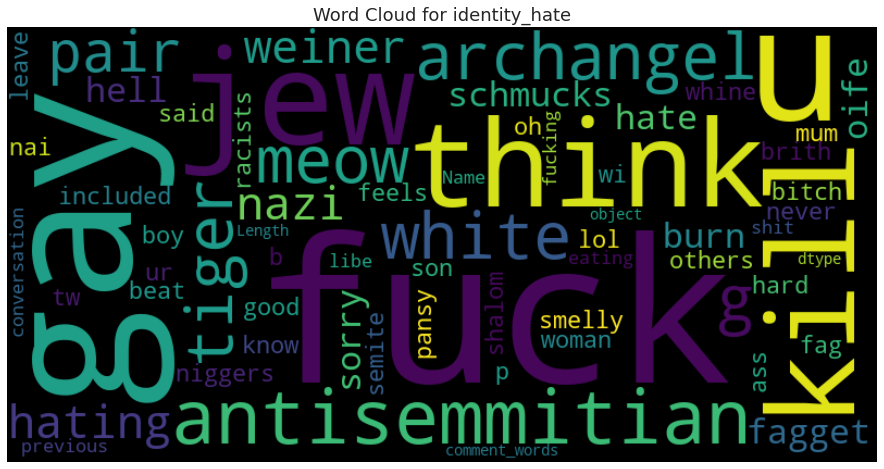

In [26]:
for output in outputs_train:
    words = str(train_data.loc[train_data[output] == 1, 'comment_words'])
    display_cloud(words, output)

### 3.2.3 Converting text for Naive Bayes model, creating training and test data

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=1000)

In [28]:
X_train_nb = word_vectorizer.fit_transform(train_data["comment_words"]).toarray()
X_test_nb = word_vectorizer.fit_transform(test_data["comment_words"]).toarray()

print("Training input shape is:", X_train_nb.shape)
print("Testing input shape is:", X_test_nb.shape)

Training input shape is: (159571, 1000)
Testing input shape is: (63978, 1000)


In [29]:
y_train_nb = train_data[outputs_train]
y_test_nb = test_data[outputs_test]

print("Training output shape is:", y_train_nb.shape)
print("Testing output shape is:", y_test_nb.shape)

Training output shape is: (159571, 7)
Testing output shape is: (63978, 7)


### 3.2.4 Converting text for LSTM model, creating training and test data

In [31]:
vocab_size = 1000 
embedding_dim = 100 
max_length = 120
trunc_type='post' 
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

Preparing training set

In [32]:
train_size = int(train_data.shape[0] * training_portion) 

train_sentences = train_data["comment_words"][:train_size]
y_train_lstm = train_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']][:train_size] 

validation_sentences = train_data["comment_words"][train_size:] 
y_val_lstm = train_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']][train_size:]

print("Train size is:", train_size)
print("Number of inputs in train data:", len(train_sentences))
print("Number of outputs in train data:", len(y_train_lstm))
print("Number of inputs in validation data:", len(validation_sentences))
print("Number of outputs in validation data:", len(y_val_lstm))

Train size is: 127656
Number of inputs in train data: 127656
Number of outputs in train data: 127656
Number of inputs in validation data: 31915
Number of outputs in validation data: 31915


In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
X_train_lstm = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length) 

print("Processed training data shape is:", X_train_lstm.shape)

Processed training data shape is: (127656, 120)


In [35]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences) 
X_val_lstm = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length) 

print("Processed validation data shape is:", X_val_lstm.shape)

Processed validation data shape is: (31915, 120)


Preparing test set

In [36]:
test_sentences = test_data["comment_words"]
y_test_lstm = test_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']]

print("Number of inputs in test data:", len(test_sentences))
print("Number of outputs in test data:", len(y_test_lstm))

Number of inputs in test data: 63978
Number of outputs in test data: 63978


In [37]:
test_sequences = tokenizer.texts_to_sequences(test_sentences) 
X_test_lstm = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length) 

print("Processed test data shape is:", X_test_lstm.shape)

Processed test data shape is: (63978, 120)


# 4. Modeling

## 4.0 Multilabel Naive Bayes (Benchmark)

### 4.0.1 Training

In [38]:
from sklearn.naive_bayes import MultinomialNB

In [39]:
clf_nb = []
for ix in range(7):
    clf_nb.append(MultinomialNB())
    clf_nb[ix].fit(X_train_nb,y_train_nb.iloc[:,ix])

### 4.0.2 Testing

In [40]:
predict_nb = []

for ix in range(7):
    predict_nb.append(clf_nb[ix].predict(X_test_nb))

predict_nb = np.asarray(np.transpose(predict_nb))

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix, classification_report, roc_auc_score

accuracy_nb = accuracy_score(y_test_nb,predict_nb)
roc_auc_score_nb = roc_auc_score(y_test_nb,predict_nb)
conf_m_nb = multilabel_confusion_matrix(y_test_nb,predict_nb)

print(classification_report(y_test_nb,predict_nb))
print("The accuracy of multilabel Naive Bayes Classifier with all labels is:", accuracy_nb)
print("ROC AUC score for multilabel Naive Bayes Classifier with all labels is:", roc_auc_score_nb)
print("Confusion matrix for multilabel Naive Bayes Classifier with all labels:\n",conf_m_nb)

              precision    recall  f1-score   support

           0       0.91      0.99      0.94     57735
           1       0.25      0.03      0.06      6090
           2       0.00      0.00      0.00       367
           3       0.13      0.01      0.02      3691
           4       0.00      0.00      0.00       211
           5       0.16      0.01      0.02      3427
           6       0.00      0.00      0.00       712

   micro avg       0.89      0.79      0.84     72233
   macro avg       0.21      0.15      0.15     72233
weighted avg       0.76      0.79      0.76     72233
 samples avg       0.89      0.89      0.89     72233

The accuracy of multilabel Naive Bayes Classifier with all labels is: 0.8909781487386289
ROC AUC score for multilabel Naive Bayes Classifier with all labels is: 0.5046784390944993
Confusion matrix for multilabel Naive Bayes Classifier with all labels:
 [[[  268  5975]
  [  791 56944]]

 [[57276   612]
  [ 5886   204]]

 [[63610     1]
  [  367    

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.1 Multilabel LSTM with Glove Embeddings

### 4.1.1 Preparing Embedding layer

In [44]:
#from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
with open('data_raw/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [45]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### 4.1.2 Training

In [64]:
clf_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],  input_length=max_length),
    tf.keras.layers.LSTM(56),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])
clf_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
clf_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          15915600  
_________________________________________________________________
lstm (LSTM)                  (None, 56)                35168     
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 28)                1596      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 203       
Total params: 15,952,567
Trainable params: 15,952,567
Non-trainable params: 0
_________________________________________________________________


In [65]:
batch_size = 128
epochs = 2

clf_lstm.fit(X_train_lstm, y_train_lstm, batch_size=batch_size, epochs=epochs,
         validation_data=(X_val_lstm, y_val_lstm))

Epoch 1/2
998/998 [==============================] - 258s 257ms/step - loss: 0.1609 - accuracy: 0.8953 - val_loss: 0.1023 - val_accuracy: 0.9329
Epoch 2/2
998/998 [==============================] - 257s 257ms/step - loss: 0.0901 - accuracy: 0.9412 - val_loss: 0.0834 - val_accuracy: 0.9449


### 4.1.3 Testing

In [66]:
predict_lstm = np.round(clf_lstm.predict(X_test_lstm))

In [67]:
accuracy_lstm = accuracy_score(y_test_lstm,predict_lstm)
conf_m_lstm = multilabel_confusion_matrix(y_test_lstm,predict_lstm)

print(classification_report(y_test_lstm,predict_lstm))
print("The accuracy of multilabel LSTM with all labels is:", accuracy_lstm)
print("ROC AUC score of multilabel LSTM with all labels is:", roc_auc_score(y_test_lstm,predict_lstm))
print("Confusion matrix for multilabel LSTM with all labels:\n", conf_m_lstm)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     57735
           1       0.68      0.58      0.63      6090
           2       0.00      0.00      0.00       367
           3       0.00      0.00      0.00      3691
           4       0.00      0.00      0.00       211
           5       0.00      0.00      0.00      3427
           6       0.00      0.00      0.00       712

   micro avg       0.94      0.82      0.87     72233
   macro avg       0.23      0.22      0.23     72233
weighted avg       0.83      0.82      0.82     72233
 samples avg       0.92      0.89      0.90     72233

The accuracy of multilabel LSTM with all labels is: 0.8744568445403107
ROC AUC score of multilabel LSTM with all labels is: 0.5816654741141303
Confusion matrix for multilabel LSTM with all labels:
 [[[ 3962  2281]
  [ 2365 55370]]

 [[56247  1641]
  [ 2570  3520]]

 [[63611     0]
  [  367     0]]

 [[60287     0]
  [ 3691     0]]

 [[63767     0]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.2 Multilabel Naive Bayes, toxic labels only

In [46]:
y_train_nb_toxic = y_train_nb.drop("neutral", axis=1)
y_test_nb_toxic = y_test_nb.drop("neutral", axis=1)
y_train_lstm_toxic = y_train_lstm.drop("neutral", axis=1)
y_val_lstm_toxic = y_val_lstm.drop("neutral", axis=1)
y_test_lstm_toxic = y_test_lstm.drop("neutral", axis=1)

### 4.2.1 Training

In [47]:
clf_nb_toxic = []
for ix in range(6):
    clf_nb_toxic.append(MultinomialNB())
    clf_nb_toxic[ix].fit(X_train_nb,y_train_nb_toxic.iloc[:,ix])

### 4.2.2 Testing

In [48]:
predict_nb_toxic = []

for ix in range(6):
    predict_nb_toxic.append(clf_nb_toxic[ix].predict(X_test_nb))

predict_nb_toxic = np.asarray(np.transpose(predict_nb_toxic))

In [50]:
accuracy_nb_toxic = accuracy_score(y_test_nb_toxic,predict_nb_toxic)
conf_m_nb_toxic = multilabel_confusion_matrix(y_test_nb_toxic,predict_nb_toxic)

print(classification_report(y_test_nb_toxic,predict_nb_toxic))
print("The accuracy of multilabel Naive Bayes Classifier with toxic labels is:", accuracy_nb_toxic)
print("ROC AUC score of multilabel Naive Bayes Classifier with toxic labels is:", roc_auc_score(y_test_nb_toxic,predict_nb_toxic))
print("Confusion matrix for multilabel Naive Bayes Classifier with toxic labels:\n",conf_m_nb_toxic)

              precision    recall  f1-score   support

           0       0.25      0.03      0.06      6090
           1       0.00      0.00      0.00       367
           2       0.13      0.01      0.02      3691
           3       0.00      0.00      0.00       211
           4       0.16      0.01      0.02      3427
           5       0.00      0.00      0.00       712

   micro avg       0.21      0.02      0.04     14498
   macro avg       0.09      0.01      0.02     14498
weighted avg       0.18      0.02      0.03     14498
 samples avg       0.00      0.00      0.00     14498

The accuracy of multilabel Naive Bayes Classifier with toxic labels is: 0.8938385069867767
ROC AUC score of multilabel Naive Bayes Classifier with toxic labels is: 0.5030225496791457
Confusion matrix for multilabel Naive Bayes Classifier with toxic labels:
 [[[57276   612]
  [ 5886   204]]

 [[63610     1]
  [  367     0]]

 [[60027   260]
  [ 3651    40]]

 [[63767     0]
  [  211     0]]

 [[60369 

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

## 4.3 Multilabel LSTM, toxic labels only

### 4.3.1 Trainig

In [68]:
clf_lstm_toxic = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],  input_length=max_length),
    tf.keras.layers.LSTM(56),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
clf_lstm_toxic.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
clf_lstm_toxic.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          15915600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 56)                35168     
_________________________________________________________________
flatten_1 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1596      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 174       
Total params: 15,952,538
Trainable params: 15,952,538
Non-trainable params: 0
_________________________________________________________________


In [69]:
batch_size = 128
epochs = 2

clf_lstm_toxic.fit(X_train_lstm, y_train_lstm_toxic, batch_size=batch_size, epochs=epochs,
         validation_data=(X_val_lstm, y_val_lstm_toxic))

Epoch 1/2
998/998 [==============================] - 258s 257ms/step - loss: 0.1322 - accuracy: 0.9514 - val_loss: 0.0754 - val_accuracy: 0.9932
Epoch 2/2
998/998 [==============================] - 261s 261ms/step - loss: 0.0684 - accuracy: 0.9941 - val_loss: 0.0657 - val_accuracy: 0.9941


### 4.3.2 Testing

In [70]:
predict_lstm_toxic = np.round(clf_lstm_toxic.predict(X_test_lstm))

In [71]:
accuracy_lstm_toxic = accuracy_score(y_test_lstm_toxic,predict_lstm_toxic)
conf_m_lstm_toxic = multilabel_confusion_matrix(y_test_lstm_toxic,predict_lstm_toxic)

print(classification_report(y_test_lstm_toxic,predict_lstm_toxic))
print("The accuracy of multilabel LSTM Classifier with toxic labels is:", accuracy_lstm_toxic)
print("ROC AUC score for multilabel LSTM Classifier with toxic labels is:", roc_auc_score(y_test_lstm_toxic,predict_lstm_toxic))
print("Confusion matrix for multilabel LSTM Classifier with toxic labels:\n", conf_m_lstm_toxic)

              precision    recall  f1-score   support

           0       0.10      1.00      0.18      6090
           1       0.00      0.00      0.00       367
           2       0.00      0.00      0.00      3691
           3       0.00      0.00      0.00       211
           4       0.00      0.00      0.00      3427
           5       0.00      0.00      0.00       712

   micro avg       0.10      0.42      0.16     14498
   macro avg       0.02      0.17      0.03     14498
weighted avg       0.04      0.42      0.07     14498
 samples avg       0.10      0.05      0.06     14498

The accuracy of multilabel LSTM Classifier with toxic labels is: 0.038857107130576135
ROC AUC score for multilabel LSTM Classifier with toxic labels is: 0.5009708983930012
Confusion matrix for multilabel LSTM Classifier with toxic labels:
 [[[  779 57109]
  [   11  6079]]

 [[63611     0]
  [  367     0]]

 [[60287     0]
  [ 3691     0]]

 [[63767     0]
  [  211     0]]

 [[60551     0]
  [ 3427   

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

## 4.4 Binary Naive Bayes: toxic/non-toxic

In [51]:
y_train_nb_bi = y_train_nb['neutral']
y_test_nb_bi = y_test_nb['neutral']
y_train_lstm_bi = y_train_lstm['neutral']
y_val_lstm_bi = y_val_lstm['neutral']
y_test_lstm_bi = y_test_lstm['neutral']

### 4.4.1 Training

In [52]:
clf_nb_bi = MultinomialNB()
clf_nb_bi.fit(X_train_nb,y_train_nb_bi)

MultinomialNB()

### 4.4.2 Testing

In [53]:
predict_nb_bi = clf_nb_bi.predict(X_test_nb)

In [54]:
accuracy_nb_bi = accuracy_score(y_test_nb_bi,predict_nb_bi)
conf_m_nb_bi = confusion_matrix(y_test_nb_bi,predict_nb_bi)

print(classification_report(y_test_nb_bi,predict_nb_bi))
print("The accuracy of Binary Naive Bayes Classifier is:", accuracy_nb_bi)
print("ROC AUC score of Binary Naive Bayes Classifier is:", roc_auc_score(y_test_nb_bi,predict_nb_bi))
print("Confusion matrix Binary Naive Bayes Classifier:\n",conf_m_nb_bi)

              precision    recall  f1-score   support

           0       0.25      0.04      0.07      6243
           1       0.91      0.99      0.94     57735

    accuracy                           0.89     63978
   macro avg       0.58      0.51      0.51     63978
weighted avg       0.84      0.89      0.86     63978

The accuracy of Binary Naive Bayes Classifier is: 0.8942448966832348
ROC AUC score of Binary Naive Bayes Classifier is: 0.5146137755866201
Confusion matrix Binary Naive Bayes Classifier:
 [[  268  5975]
 [  791 56944]]


## 4.5 Binary LSTM: toxic/non-toxic

### 4.5.1 Training

In [102]:
clf_lstm_bi = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],  input_length=max_length),
    tf.keras.layers.LSTM(56),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
clf_lstm_bi.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
clf_lstm_bi.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 120, 100)          15915600  
_________________________________________________________________
lstm_9 (LSTM)                (None, 56)                35168     
_________________________________________________________________
flatten_9 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 28)                1596      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 29        
Total params: 15,952,393
Trainable params: 15,952,393
Non-trainable params: 0
_________________________________________________________________


In [103]:
batch_size = 128
epochs = 2

clf_lstm_bi.fit(X_train_lstm, y_train_lstm_bi, batch_size=batch_size, epochs=epochs,
         validation_data=(X_val_lstm, y_val_lstm_bi))

Epoch 1/2
998/998 [==============================] - 257s 256ms/step - loss: 0.2830 - accuracy: 0.9113 - val_loss: 0.1693 - val_accuracy: 0.9454
Epoch 2/2
998/998 [==============================] - 256s 257ms/step - loss: 0.1580 - accuracy: 0.9479 - val_loss: 0.1490 - val_accuracy: 0.9502


### 4.5.2 Testing

In [104]:
predict_lstm_bi = np.round(clf_lstm_bi.predict(X_test_lstm))

In [105]:
accuracy_lstm_bi = accuracy_score(y_test_lstm_bi,predict_lstm_bi)
conf_m_lstm_bi = confusion_matrix(y_test_lstm_bi,predict_lstm_bi)

print(classification_report(y_test_lstm_bi,predict_lstm_bi))
print("The accuracy of Binary LSTM Classifier is:", accuracy_lstm_bi)
print("Confusion matrix for Binary LSTM Classifier:\n", conf_m_lstm_bi)
print("ROC AUC score of Binary LSTM Classifier is:", roc_auc_score(y_test_lstm_bi,predict_lstm_bi))

              precision    recall  f1-score   support

           0       0.56      0.70      0.63      6243
           1       0.97      0.94      0.95     57735

    accuracy                           0.92     63978
   macro avg       0.77      0.82      0.79     63978
weighted avg       0.93      0.92      0.92     63978

The accuracy of Binary LSTM Classifier is: 0.9180343242989778
Confusion matrix for Binary LSTM Classifier:
 [[ 4373  1870]
 [ 3374 54361]]
ROC AUC score of Binary LSTM Classifier is: 0.8210125493839668


## 4.6 Binary Naive Bayes with SMOT

In [55]:
from imblearn.over_sampling import SMOTE

In [56]:
y_train_nb_sm = y_train_nb['neutral']
y_test_nb_sm = y_test_nb['neutral']
y_train_lstm_sm = y_train_lstm['neutral']
y_val_lstm_sm = y_val_lstm['neutral']
y_test_lstm_sm = y_test_lstm['neutral']

In [57]:
X_train_nb_sm = X_train_nb
X_test_nb_sm = X_test_nb
X_train_lstm_sm = X_train_lstm
X_val_lstm_sm = X_val_lstm
X_test_lstm_sm = X_test_lstm

In [58]:
sm = SMOTE(random_state=27)

### 4.6.1 Training

In [59]:
X_train_nb_sm, y_train_nb_sm = sm.fit_resample(X_train_nb_sm, y_train_nb_sm)
print(X_train_nb_sm.shape)
print(y_train_nb_sm.shape)

(286692, 1000)
(286692,)


In [60]:
clf_nb_sm = MultinomialNB()
clf_nb_sm.fit(X_train_nb_sm,y_train_nb_sm)

MultinomialNB()

### 4.6.2 Testing

In [62]:
predict_nb_sm = clf_nb_sm.predict(X_test_nb_sm)

In [63]:
accuracy_nb_sm = accuracy_score(y_test_nb_sm,predict_nb_sm)
conf_m_nb_sm = confusion_matrix(y_test_nb_sm,predict_nb_sm)

print(classification_report(y_test_nb_sm,predict_nb_sm))
print("The accuracy of Binary Naive Bayes Classifier with SMOTE is:", accuracy_nb_sm)
print("ROC AUC score of Binary Naive Bayes Classifier with SMOTE is", roc_auc_score(y_test_nb_sm,predict_nb_sm))
print("Confusion matrix for Binary Naive Bayes Classifier with SMOTE:\n",conf_m_nb_sm)

              precision    recall  f1-score   support

           0       0.13      0.24      0.17      6243
           1       0.91      0.83      0.87     57735

    accuracy                           0.77     63978
   macro avg       0.52      0.53      0.52     63978
weighted avg       0.83      0.77      0.80     63978

The accuracy of Binary Naive Bayes Classifier with SMOTE is: 0.7742661539904342
ROC AUC score of Binary Naive Bayes Classifier with SMOTE is 0.5344958304457137
Confusion matrix for Binary Naive Bayes Classifier with SMOTE:
 [[ 1477  4766]
 [ 9676 48059]]


## 4.7 Binary LSTM with SMOTE

In [110]:
X_train_lstm_sm, y_train_lstm_sm = sm.fit_resample(X_train_lstm_sm, y_train_lstm_sm)
X_val_lstm_sm, y_val_lstm_sm = sm.fit_resample(X_val_lstm_sm, y_val_lstm_sm)
print(X_train_lstm_sm.shape)
print(y_train_lstm_sm.shape)
print(X_val_lstm_sm.shape)
print(y_val_lstm_sm.shape)

(229312, 120)
(229312,)
(57380, 120)
(57380,)


### 4.7.1 Training

In [111]:
clf_lstm_sm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],  input_length=max_length),
    tf.keras.layers.LSTM(56),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
clf_lstm_sm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
clf_lstm_sm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 120, 100)          15915600  
_________________________________________________________________
lstm_11 (LSTM)               (None, 56)                35168     
_________________________________________________________________
flatten_11 (Flatten)         (None, 56)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 28)                1596      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 29        
Total params: 15,952,393
Trainable params: 15,952,393
Non-trainable params: 0
_________________________________________________________________


In [112]:
batch_size = 128
epochs = 2

clf_lstm_sm.fit(X_train_lstm_sm, y_train_lstm_sm, batch_size=batch_size, epochs=epochs,
         validation_data=(X_val_lstm_sm, y_val_lstm_sm))

Epoch 1/2
1792/1792 [==============================] - 462s 257ms/step - loss: 0.6719 - accuracy: 0.5486 - val_loss: 0.6446 - val_accuracy: 0.5914
Epoch 2/2
1792/1792 [==============================] - 461s 257ms/step - loss: 0.5419 - accuracy: 0.7177 - val_loss: 0.4278 - val_accuracy: 0.8035


### 4.7.2 Testing

In [113]:
predict_lstm_sm = np.round(clf_lstm_sm.predict(X_test_lstm))

In [114]:
accuracy_lstm_sm = accuracy_score(y_test_lstm_sm,predict_lstm_sm)
conf_m_lstm_sm = confusion_matrix(y_test_lstm_sm,predict_lstm_sm)

print(classification_report(y_test_lstm_sm,predict_lstm_sm))
print("The accuracy of Binary LSTM Classifier with SMOTE is:", accuracy_lstm_sm)
print("ROC AUC score of Binary LSTM Classifier with SMOTE is", roc_auc_score(y_test_lstm_sm,predict_lstm_sm))
print("Confusion matrix for Binary LSTM Classifier with SMOTE:\n", conf_m_lstm_sm)

              precision    recall  f1-score   support

           0       0.19      0.85      0.32      6243
           1       0.97      0.62      0.76     57735

    accuracy                           0.64     63978
   macro avg       0.58      0.73      0.54     63978
weighted avg       0.90      0.64      0.71     63978

The accuracy of Binary LSTM Classifier with SMOTE is: 0.6394541873769108
ROC AUC score of Binary LSTM Classifier with SMOTE is 0.7333758688920992
Confusion matrix for Binary LSTM Classifier with SMOTE:
 [[ 5307   936]
 [22131 35604]]
